# ResNet 34-layers
: 잔차(residual)을 최소화 해준다

: 152개 layers을 가진다 -> top-5 error 낮아짐.

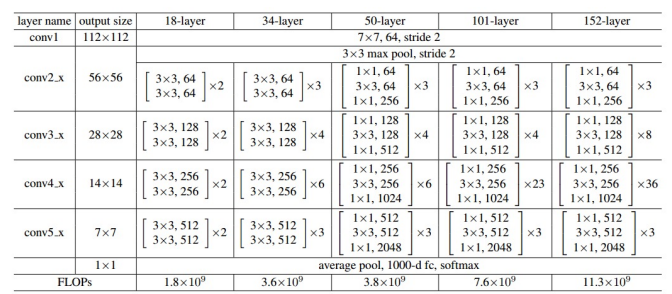

In [1]:

import torch
import torch.nn as nn


## Model

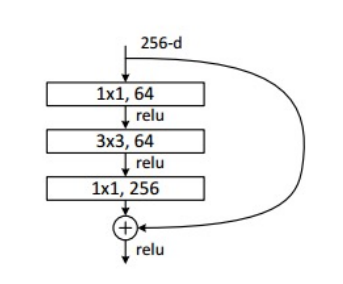

In [6]:
class BasicBlock(nn.Module):
    expansion =1
    def __init__(self, in_channels, out_channels,stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels,out_channels, kernel_size=3,stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)     #각채널 평균/분산 계산 정규화 출력 생성 -> graident vanishing 해결
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #잔차 연결 residual connection
        self.shortcut = nn.Sequential()  #초기화

        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

        
        """ 
        n.Conv2d()와 nn.BatchNorm2d()를 사용하여 1x1 컨볼루션과 배치 정규화를 수행하고, 
        입력 채널 수와 출력 채널 수를 맞춰준다.
        네트워크의 깊이를 증가시켜도 안정적으로 학습할 수 있도록 도와준다.
        """

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # shortcut을 할 땐 기존 x값 그대로 사용 -> 잔차
        # x + residual -> 입력과 출력의크기를 일정하게 만들어줌 -> 정규화 -> ReLU
        out += self.shortcut(residual)
        out = self.relu(out)


        return out





In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        #input (3,112,112)
        self.conv1 = nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3, bias=False)
        #(64,56,56)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #(64,28,28)

        #Residual Block 레이어들을 생성하기 위해 _make_layer 호출
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avepool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512* block.expansion, num_classes)



    ########## '_'가 붙은 함수 : 내부 매서드 -> class내에서 반복적으로 사용됨
    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        
        self.in_channels = out_channels * block.expansion   #in_channel 업데이트

        # residual block생성, layer추가
        for _ in range(1, blocks):
            #in_channel -> 이전 설정한 출력/
            layers.append(block(self.in_channels, out_channels))
        
        print('layers', layers)
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avepool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

        

In [14]:
def resnet34(num_classes = 1000) :
    return ResNet(BasicBlock, [3,4,6,3], num_classes)


model = resnet34(num_classes = 1000)
inputs = torch.randn(1,3,224,224)
output = model(inputs)
print(output)

layers [BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
), BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
), BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu)

RuntimeError: The size of tensor a (56) must match the size of tensor b (28) at non-singleton dimension 3